In [14]:
import tensorflow as tf
import os

# 各フォルダパス
skins_dir = 'C:/Users/Owner/Desktop/archive/Skins'
missing_dir = 'C:/Users/Owner/Desktop/archive/Missing'
masks_dir = 'C:/Users/Owner/Desktop/archive/Masks'

def load_image(path, channels=4):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]に正規化
    return image

def load_sample(file_name):
    # file_name は Tensor で、ファイル名のみが入っている前提
    skin_path = tf.strings.join([skins_dir, file_name], separator='/')
    
    missing_file = tf.strings.join(["missing_", file_name])
    missing_path = tf.strings.join([missing_dir, missing_file], separator='/')
    
    mask_file = tf.strings.join(["mask_", file_name])
    mask_path = tf.strings.join([masks_dir, mask_file], separator='/')
    
    skin = load_image(skin_path, channels=4)
    missing = load_image(missing_path, channels=4)
    mask = load_image(mask_path, channels=1)  # マスクは1チャネル
    
    # 入力は欠損画像とマスクをチャネル方向に連結 (例: shape (64,64,5))
    input_image = tf.concat([missing, mask], axis=-1)
    return input_image, skin

# 例：全てのスキン画像のファイルリストから最初の1000件のみを使用する場合
file_names = tf.data.Dataset.list_files(os.path.join(skins_dir, '*.png'))
file_names = file_names.take(1000)  # ここでファイル数を限定

# 各サンプルの読み込みと前処理
dataset = file_names.map(lambda fn: load_sample(tf.strings.split(fn, os.sep)[-1]))
dataset = dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size=3, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    conv = conv_block(x, filters)
    conv = conv_block(conv, filters)
    pool = layers.MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    up = layers.UpSampling2D((2,2))(x)
    up = layers.Concatenate()([up, skip])
    conv = conv_block(up, filters)
    conv = conv_block(conv, filters)
    return conv

def build_unet(input_shape=(64, 64, 5)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    
    # Bottleneck
    b = conv_block(p2, 128)
    b = conv_block(b, 128)
    
    # Decoder
    d2 = decoder_block(b, s2, 64)
    d1 = decoder_block(d2, s1, 32)
    
    # 出力層：RGBA出力のため4チャネル
    outputs = layers.Conv2D(4, (1,1), padding='same', activation='sigmoid')(d1)
    
    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 64, 64, 32)   1472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 64, 32)  128         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_20 (Activation)     (None, 64, 64, 32)   0           ['batch_normalization_20[0]

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size=3, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def encoder_block(x, filters):
    conv = conv_block(x, filters)
    conv = conv_block(conv, filters)
    pool = layers.MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(x, skip, filters):
    up = layers.UpSampling2D((2, 2))(x)
    up = layers.Concatenate()([up, skip])
    conv = conv_block(up, filters)
    conv = conv_block(conv, filters)
    return conv

def self_attention_block(x):
    # x: (batch, height, width, channels)
    channels = x.shape[-1]
    # クエリ、キー、バリューの生成
    query = layers.Conv2D(channels // 8, kernel_size=1, padding='same')(x)
    key   = layers.Conv2D(channels // 8, kernel_size=1, padding='same')(x)
    value = layers.Conv2D(channels, kernel_size=1, padding='same')(x)
    
    # 空間次元を平坦化 (batch, H*W, channels//8) などに変換
    shape = tf.shape(x)
    height, width = x.shape[1], x.shape[2]  # 静的な次元（例: 16,16など）を利用
    query_flat = layers.Reshape((height * width, channels // 8))(query)
    key_flat   = layers.Reshape((height * width, channels // 8))(key)
    value_flat = layers.Reshape((height * width, channels))(value)
    
    # Attentionスコアの計算: (batch, H*W, H*W)
    scores = layers.Dot(axes=(2, 2))([query_flat, key_flat])
    attention = layers.Activation('softmax')(scores)
    
    # 重み付き和を計算: (batch, H*W, channels)
    out_flat = layers.Dot(axes=(2, 1))([attention, value_flat])
    
    # 元の空間次元に復元
    out = layers.Reshape((height, width, channels))(out_flat)
    # 残差接続
    out = layers.Add()([x, out])
    return out

def build_unet_with_attention(input_shape=(64, 64, 5)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    
    # Bottleneck
    b = conv_block(p2, 128)
    b = conv_block(b, 128)
    
    # Self-Attentionブロックをボトルネックに追加
    b = self_attention_block(b)
    
    # Decoder
    d2 = decoder_block(b, s2, 64)
    d1 = decoder_block(d2, s1, 32)
    
    # 出力層：RGBA出力のため4チャネル
    outputs = layers.Conv2D(4, (1,1), padding='same', activation='sigmoid')(d1)
    
    model = models.Model(inputs, outputs)
    return model

model = build_unet_with_attention()
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 64, 64, 32)   1472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_30 (BatchN  (None, 64, 64, 32)  128         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_31 (Activation)     (None, 64, 64, 32)   0           ['batch_normalization_30[0]

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mae')  # 必要に応じてマスク重み付き損失関数へ変更

# TensorBoardやチェックポイントの設定
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('checkpoints/model_{epoch:02d}.h5', monitor='loss', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

model.fit(dataset, epochs=100, callbacks=callbacks)


Epoch 1/100
32/32 [==============================] - 5s 42ms/step - loss: 0.4205
Epoch 2/100
32/32 [==============================] - 3s 45ms/step - loss: 0.3532
Epoch 3/100
32/32 [==============================] - 3s 43ms/step - loss: 0.3299
Epoch 4/100
32/32 [==============================] - 3s 44ms/step - loss: 0.3150
Epoch 5/100
32/32 [==============================] - 3s 43ms/step - loss: 0.3064
Epoch 6/100
32/32 [==============================] - 3s 45ms/step - loss: 0.2936
Epoch 7/100
32/32 [==============================] - 3s 40ms/step - loss: 0.2873
Epoch 8/100
32/32 [==============================] - 3s 42ms/step - loss: 0.2778
Epoch 9/100
32/32 [==============================] - 3s 41ms/step - loss: 0.2707
Epoch 10/100
32/32 [==============================] - 3s 39ms/step - loss: 0.2634
Epoch 11/100
32/32 [==============================] - 3s 43ms/step - loss: 0.2564
Epoch 12/100
32/32 [==============================] - 3s 39ms/step - loss: 0.2497
Epoch 13/100
32/32 [=====

In [23]:
model.save('U_NET/UNETsa_1000_2.h5')

1/1 [==============================] - 0s 242ms/step


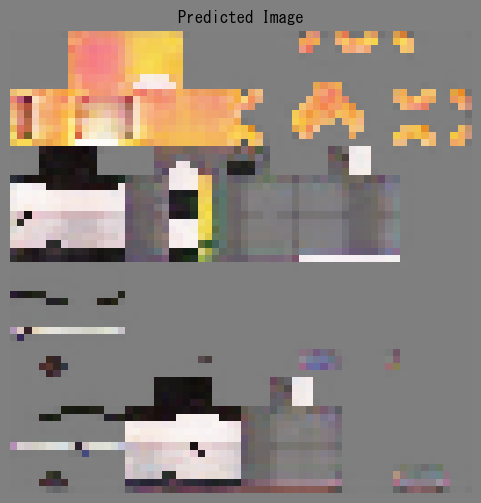

In [24]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

missing_image_path = 'Skins/0_missing.png'
mask_image_path = 'Skins/0_mask.png'

def load_image(path, channels=4):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]に正規化
    return image

missing = load_image(missing_image_path, channels=4)
mask = load_image(mask_image_path, channels=1)

missing = missing * mask

# 入力は欠損画像とマスクをチャネル方向に連結
input_image = tf.concat([missing, mask], axis=-1)

# バッチ次元を追加
input_image = tf.expand_dims(input_image, 0)

# 保存された学習済みモデルを読み込む
model = load_model('U_NET/UNETsa_1000_2.h5')

predicted_image = model.predict(input_image)[0]

# 予測結果を表示

plt.figure(figsize=(6, 6)).set(facecolor='gray')
plt.imshow(predicted_image)
plt.title('Predicted Image')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 242ms/step
推論完了: 000005406f824b6c8136e244c2199eb4.png
1/1 [==============================] - 0s 20ms/step
推論完了: 00000b63941d43e1bbf67dd05edb2a75.png
1/1 [==============================] - 0s 19ms/step
推論完了: 0000101a3d5e45f7aac735ac604d4503.png
1/1 [==============================] - 0s 21ms/step
推論完了: 00001a2825cf4de3bc3ca9fa956cd5e5.png
1/1 [==============================] - 0s 19ms/step
推論完了: 000021bd7b774cae8a4081098ce8fb87.png
1/1 [==============================] - 0s 21ms/step
推論完了: 000038872f4046cd959f21006a346980.png
1/1 [==============================] - 0s 20ms/step
推論完了: 00004361da1b4a528ada2caf9a104162.png
1/1 [==============================] - 0s 20ms/step
推論完了: 0000566aa28347c4940654afc438008b.png
1/1 [==============================] - 0s 20ms/step
推論完了: 00005e767e5a4f47a679a54b9e40abc9.png
1/1 [==============================] - 0s 22ms/step
推論完了: 00006a111c4d466198dba2bc5731f45c.png
1/1 [==============================] - 0s 20ms/st

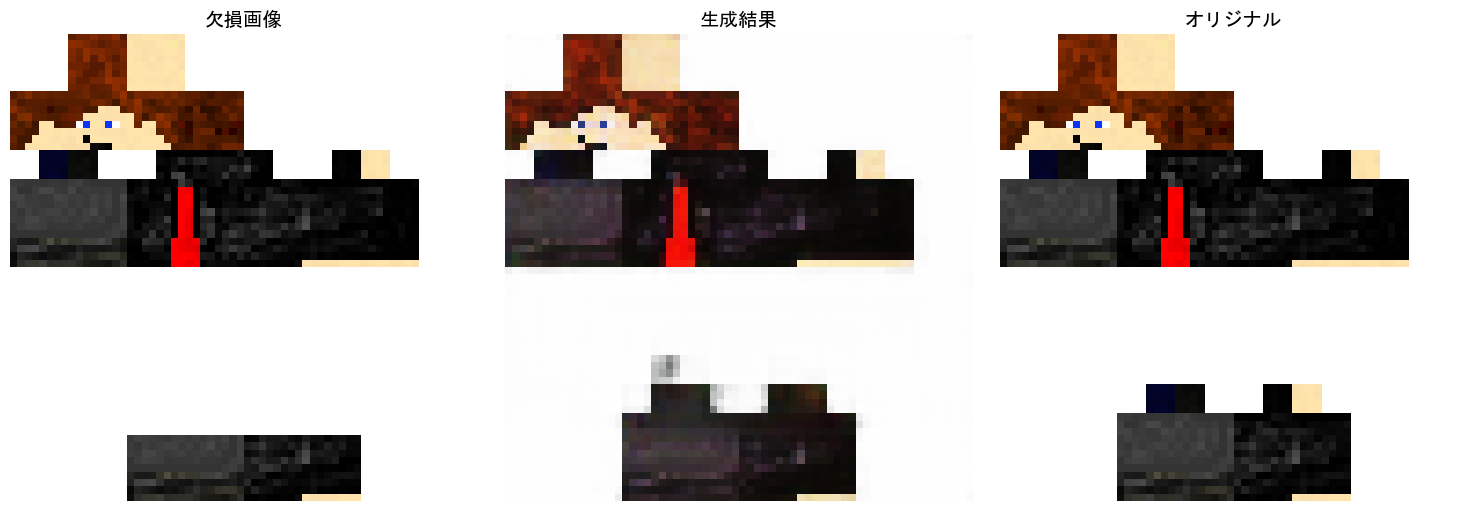

処理中: 00000b63941d43e1bbf67dd05edb2a75.png
1/1 [==============================] - 0s 20ms/step


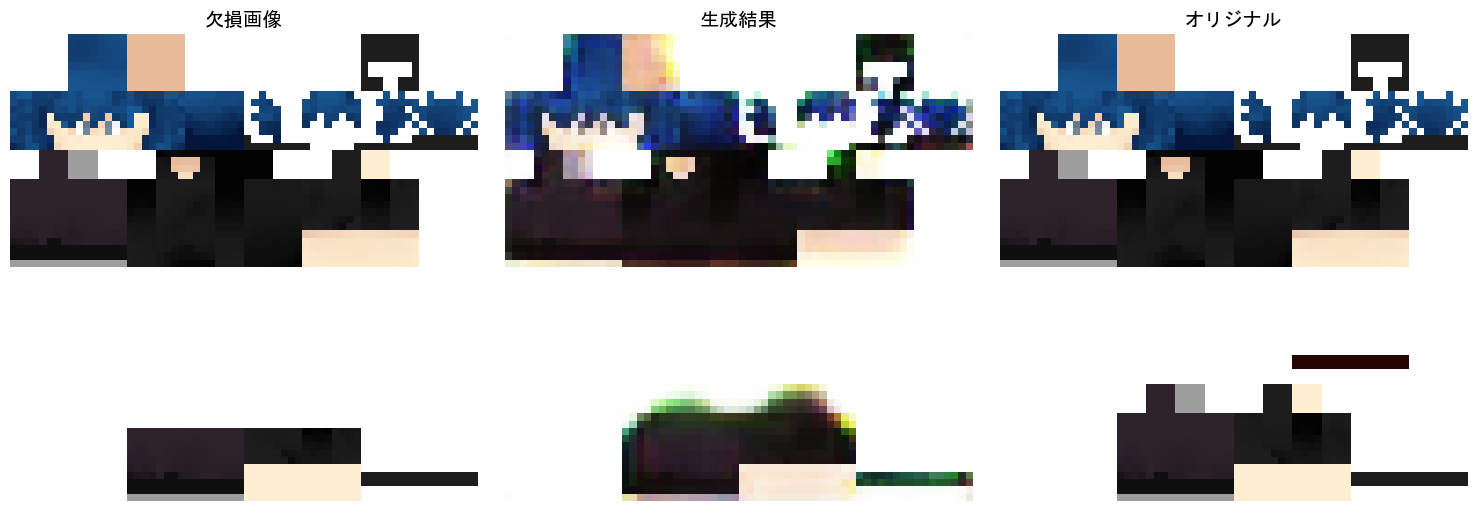

処理中: 0000101a3d5e45f7aac735ac604d4503.png
1/1 [==============================] - 0s 20ms/step


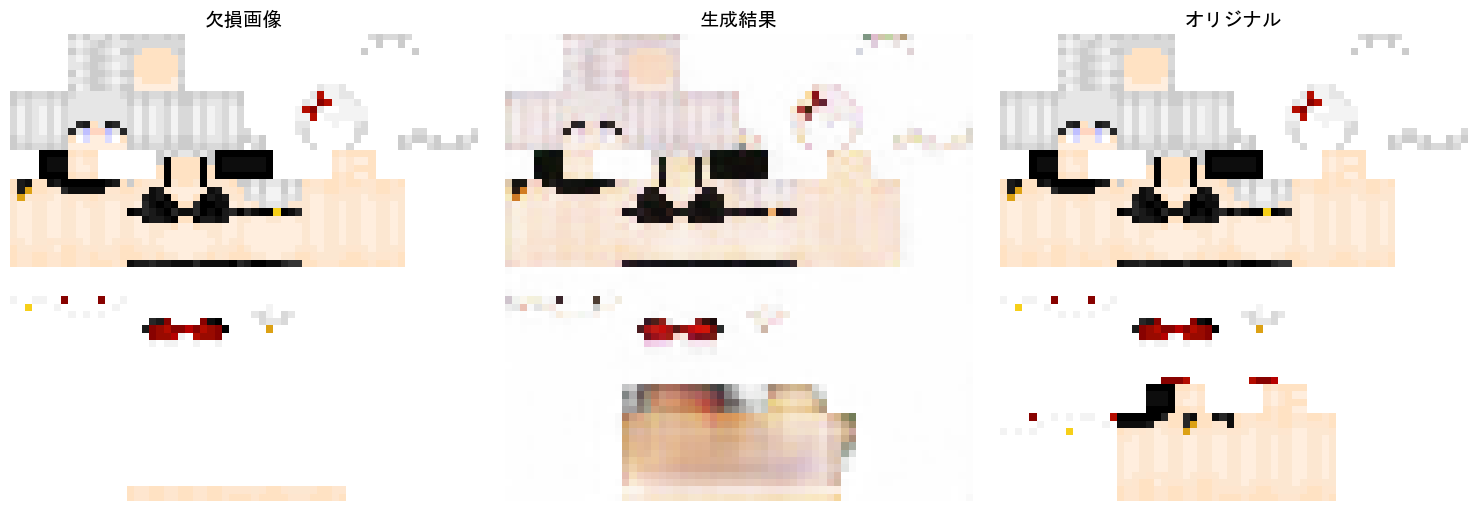

処理中: 00001a2825cf4de3bc3ca9fa956cd5e5.png
1/1 [==============================] - 0s 19ms/step


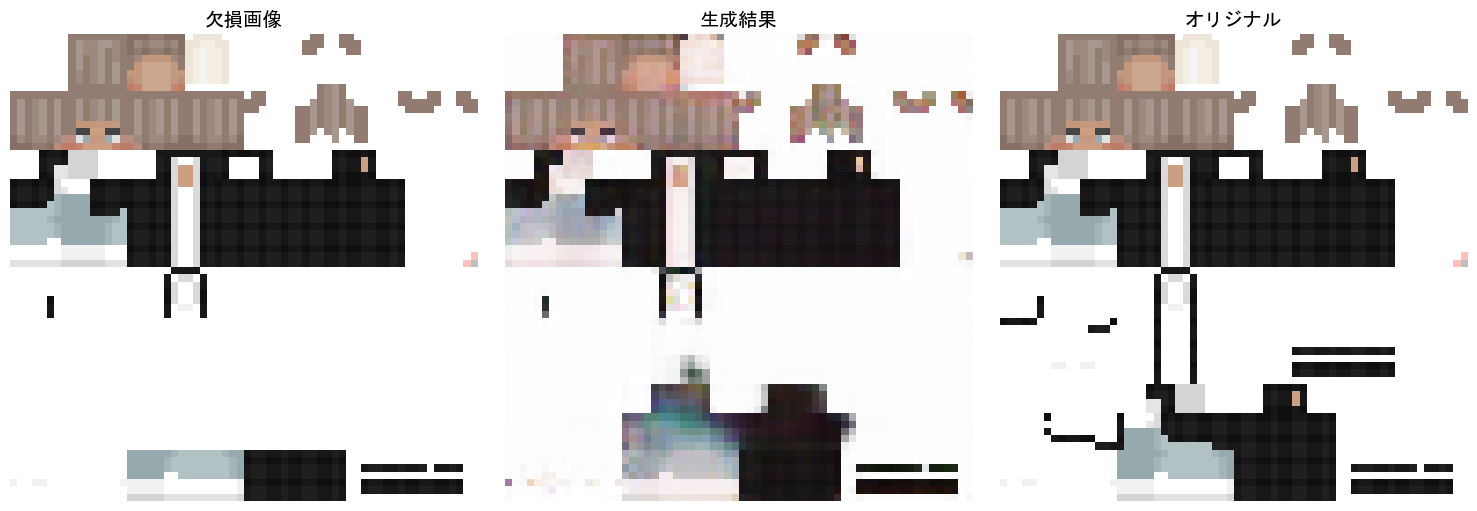

処理中: 000021bd7b774cae8a4081098ce8fb87.png
1/1 [==============================] - 0s 19ms/step


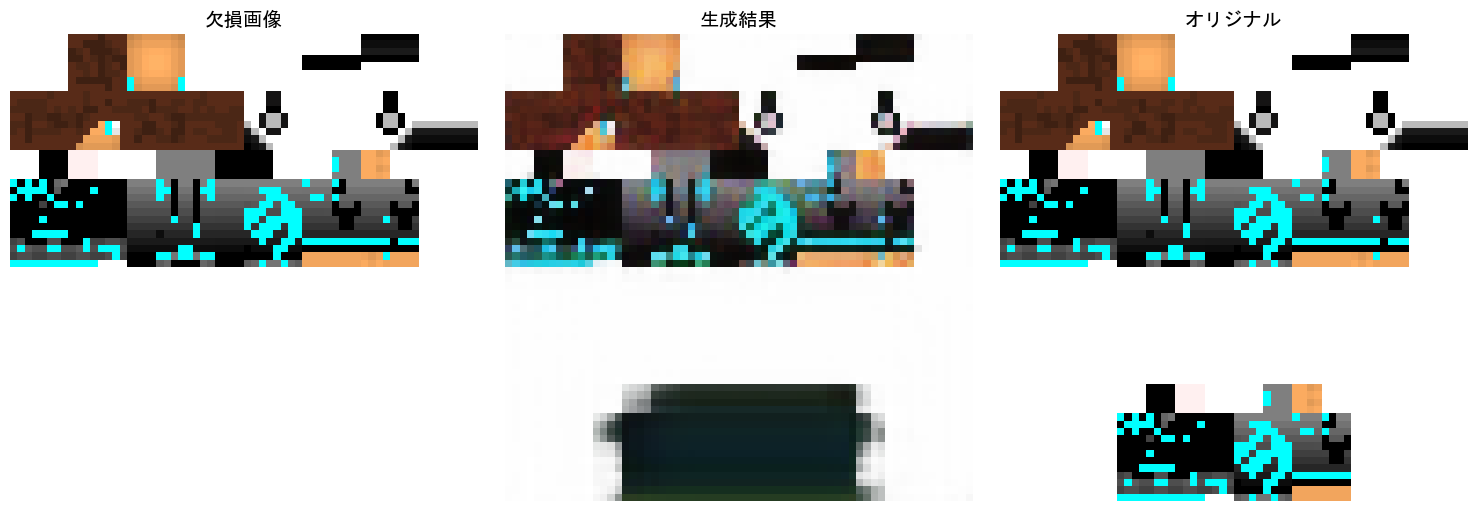

処理中: 000038872f4046cd959f21006a346980.png
1/1 [==============================] - 0s 22ms/step


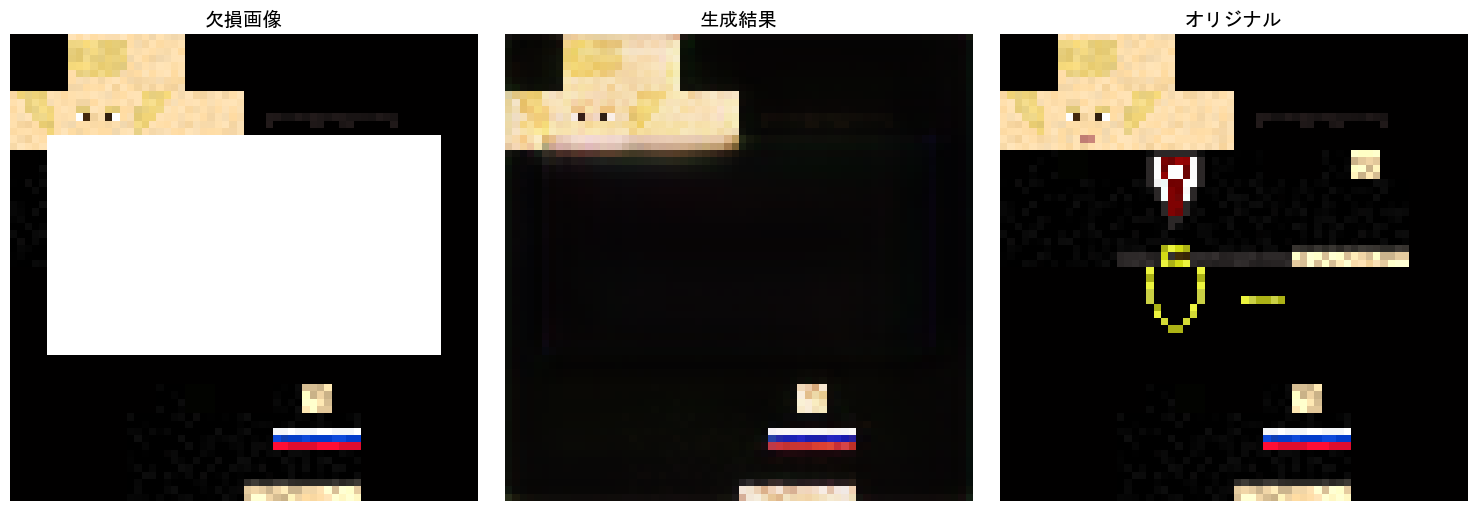

処理中: 00004361da1b4a528ada2caf9a104162.png
1/1 [==============================] - 0s 19ms/step


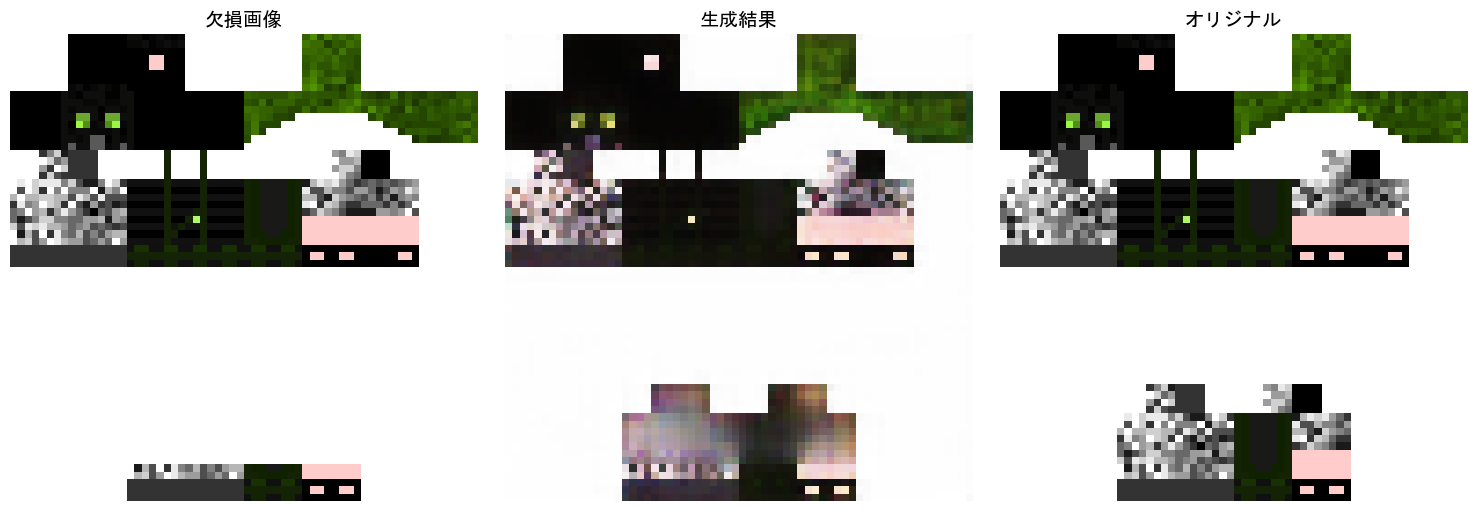

処理中: 0000566aa28347c4940654afc438008b.png
1/1 [==============================] - 0s 21ms/step


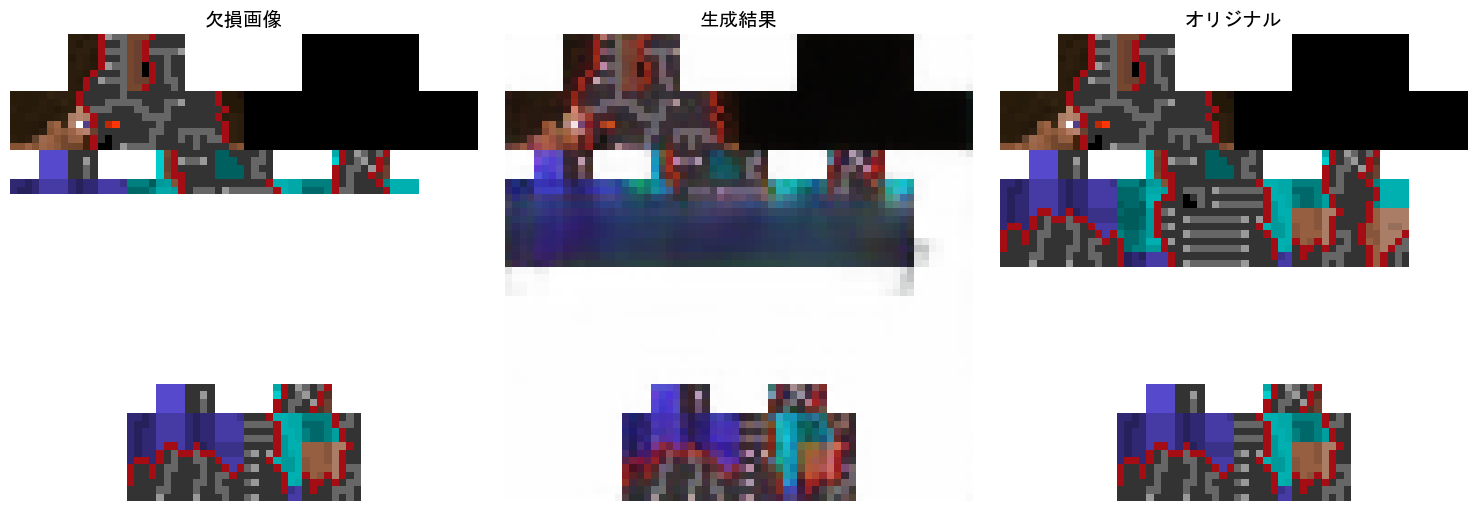

処理中: 00005e767e5a4f47a679a54b9e40abc9.png
1/1 [==============================] - 0s 18ms/step


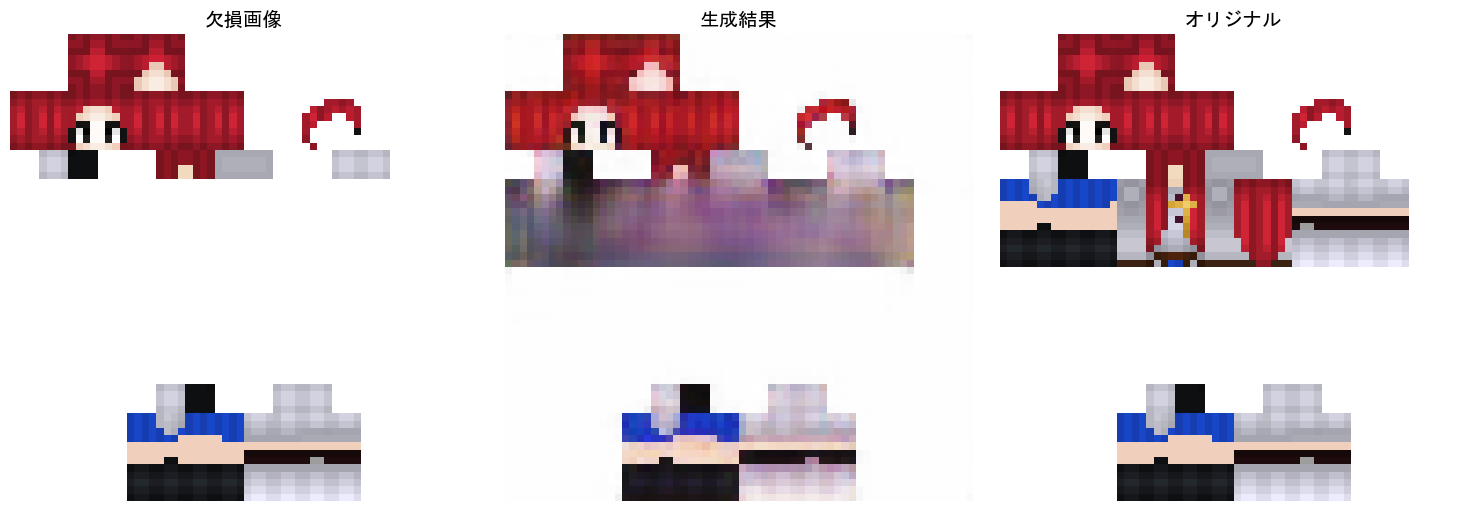

処理中: 00006a111c4d466198dba2bc5731f45c.png
1/1 [==============================] - 0s 21ms/step


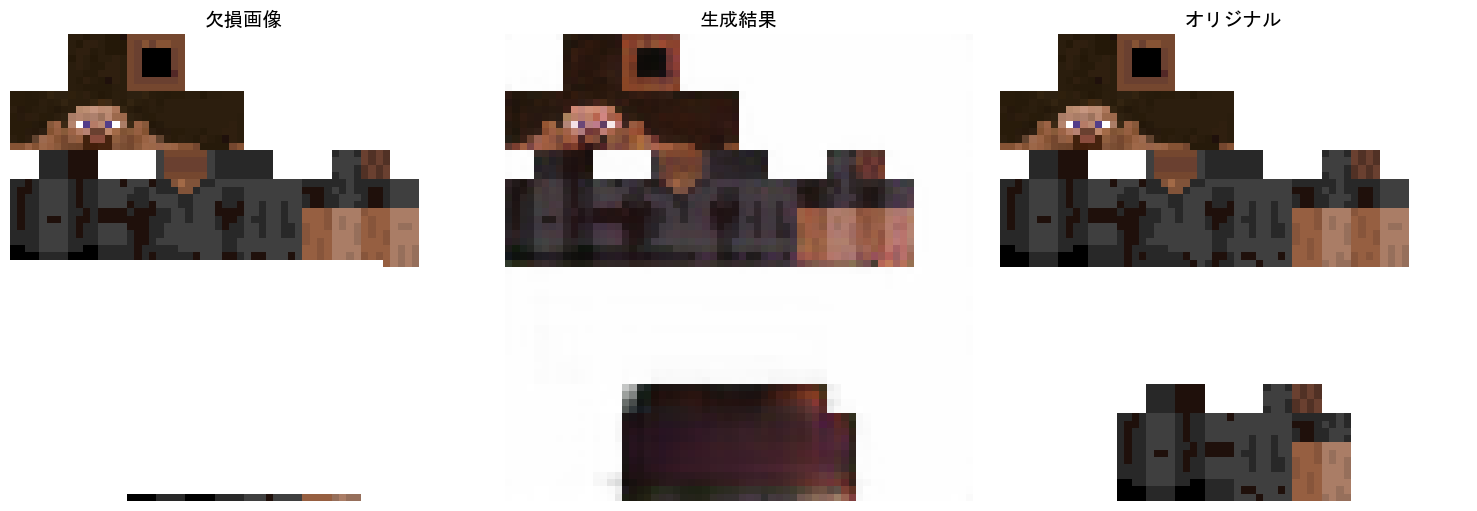

処理中: 00006cafa18c4fc79949685f3d8c67a3.png
1/1 [==============================] - 0s 45ms/step


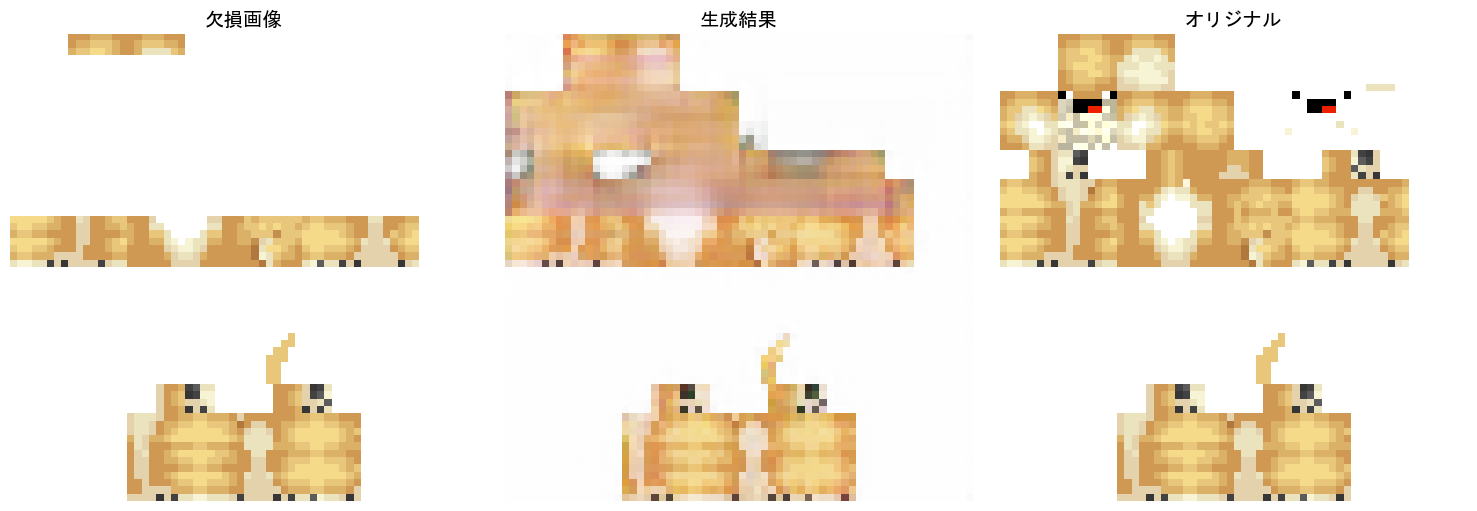

処理中: 0000861b7aee4af99bed0b5d4747143c.png
1/1 [==============================] - 0s 20ms/step


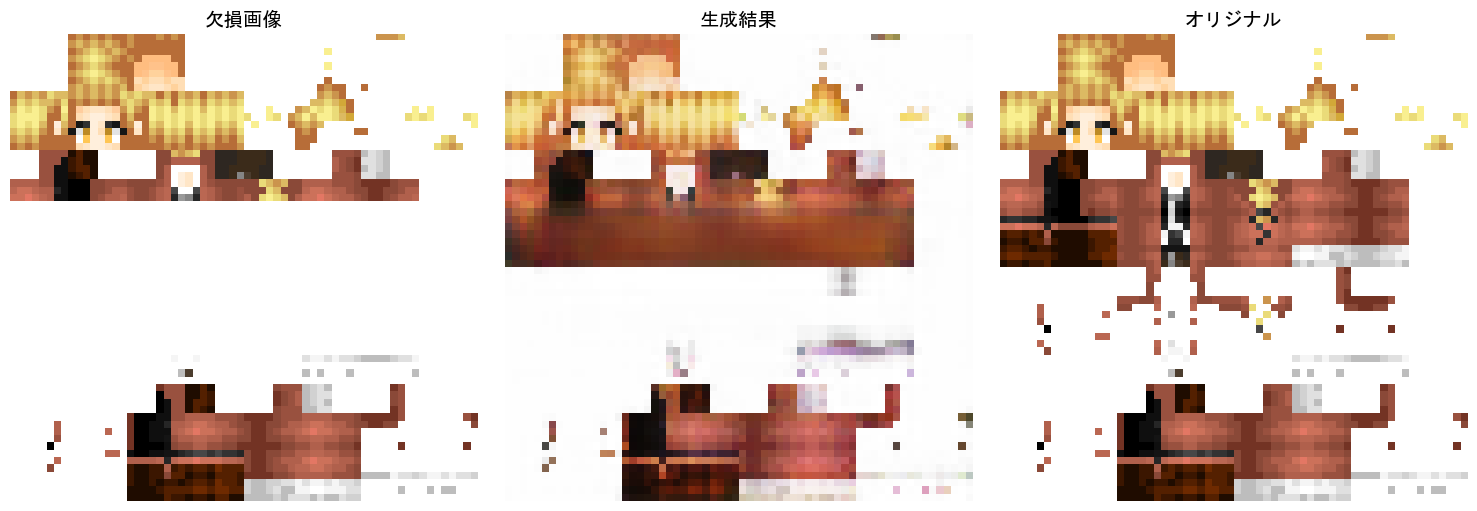

処理中: 0000c4eb1fa94a0e872359f2defb4e6e.png
1/1 [==============================] - 0s 22ms/step


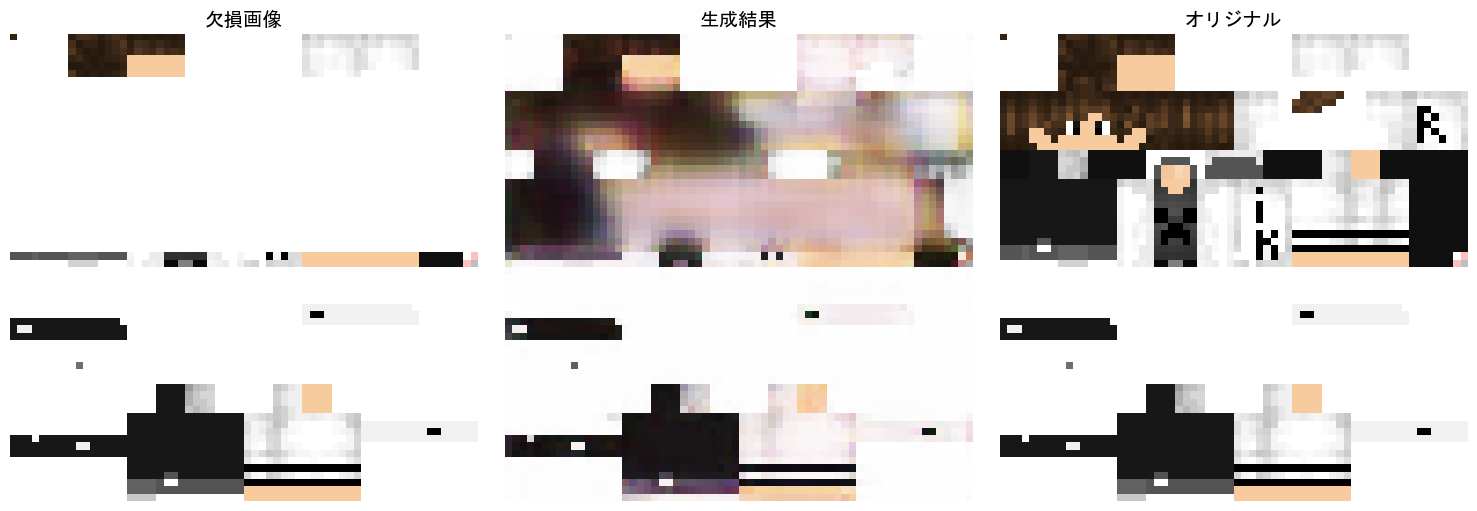

処理中: 0000cd004853453b919e01bbbcefcb09.png
1/1 [==============================] - 0s 20ms/step


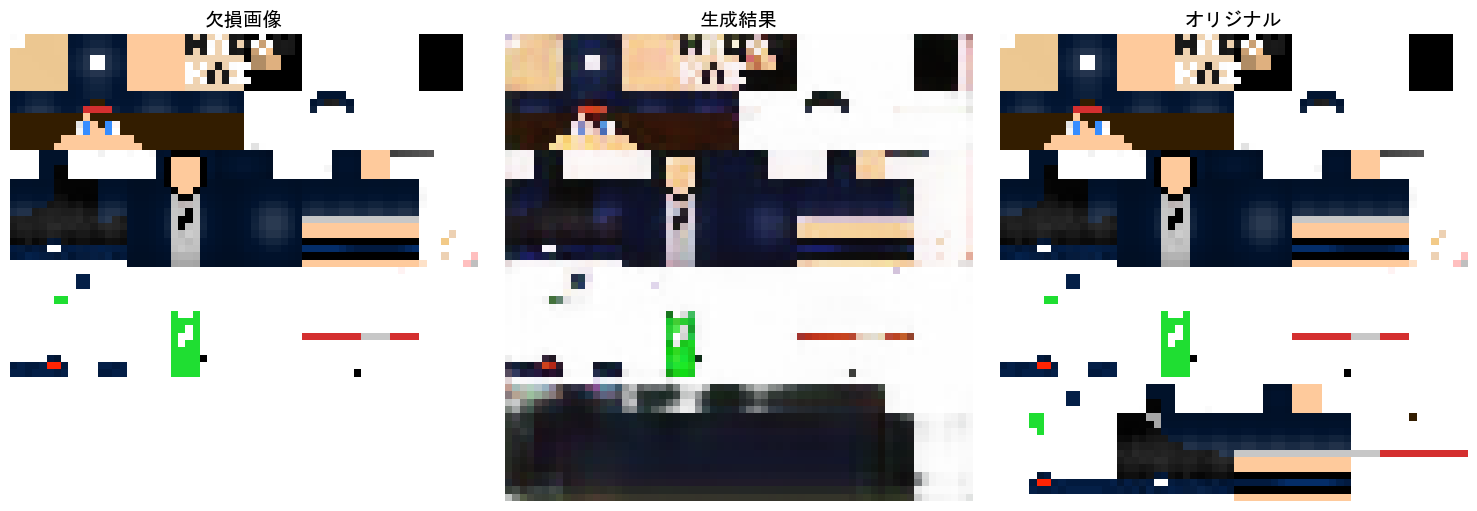

処理中: 0000d0c8b00b449280082601e43c1bd9.png
1/1 [==============================] - 0s 20ms/step


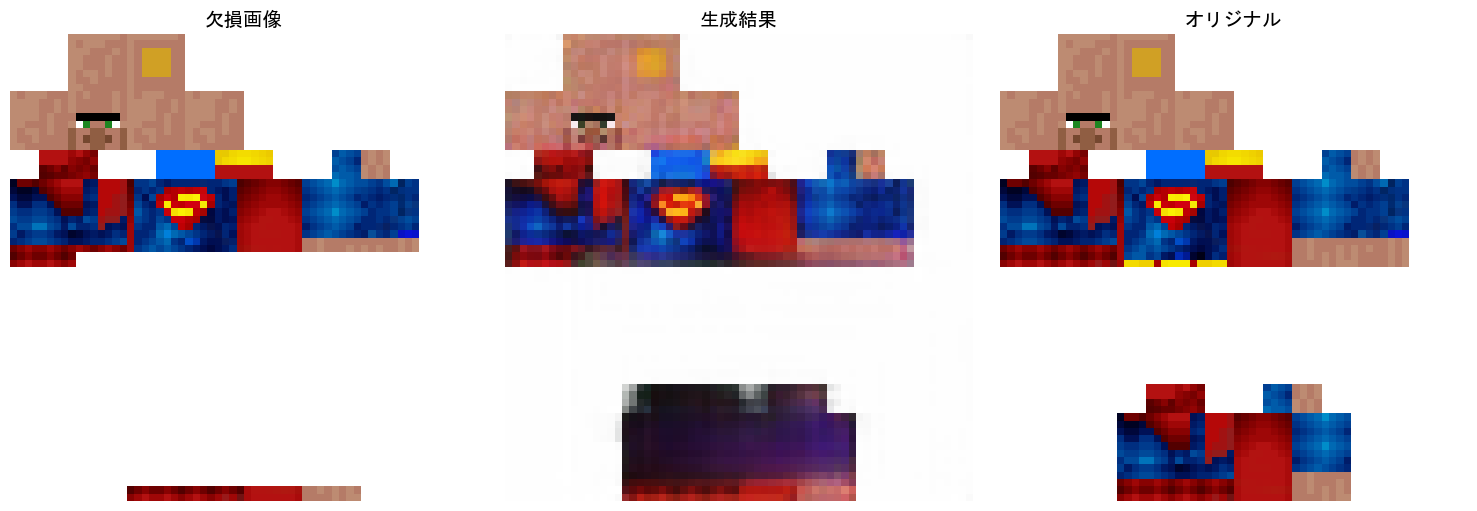

処理中: 0001048719354d2b98ed231400dd0f57.png
1/1 [==============================] - 0s 20ms/step


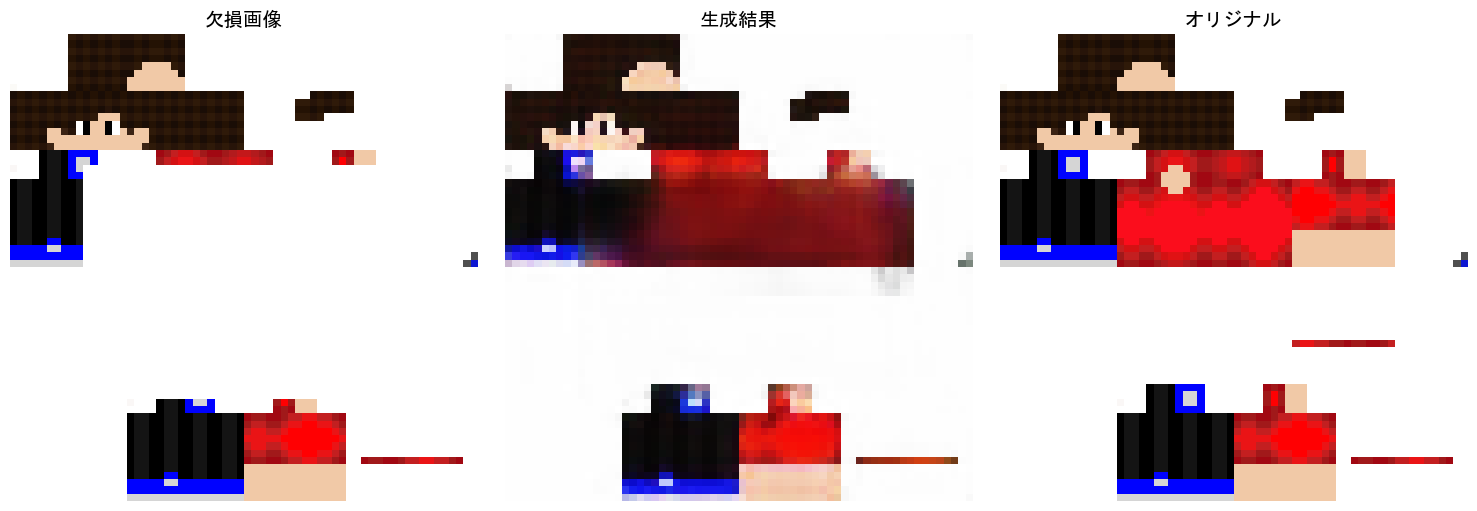

処理中: 00010ec0f1bf4f5495757cb2a897b559.png
1/1 [==============================] - 0s 21ms/step


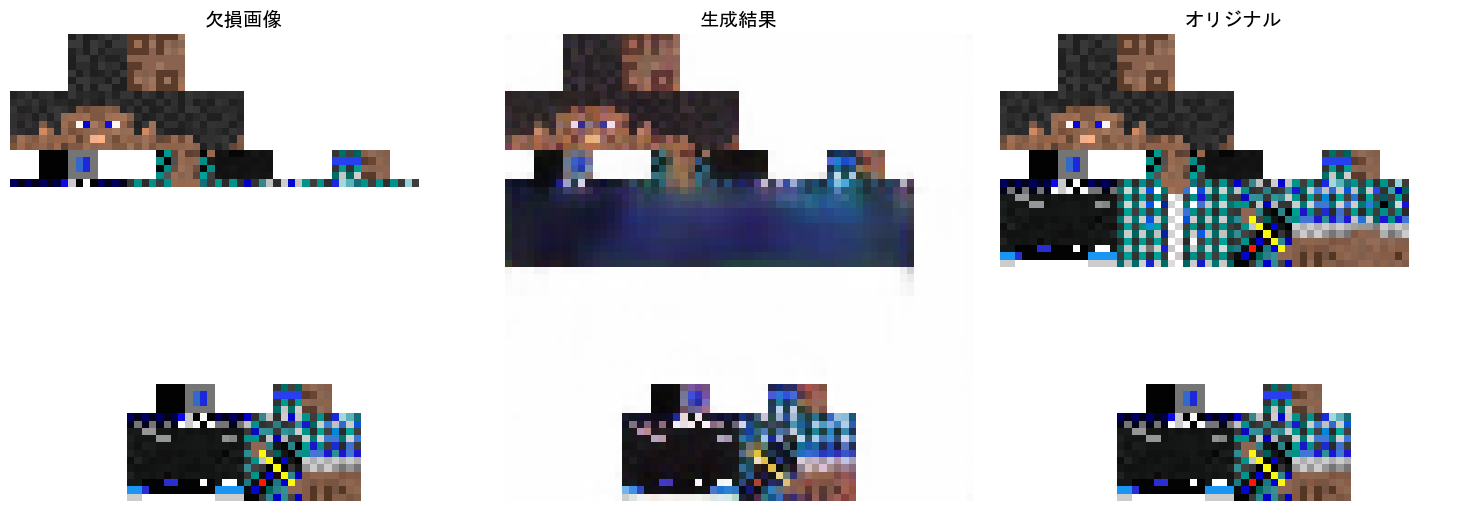

処理中: 000115f965b240de9c3fa58a630dea55.png
1/1 [==============================] - 0s 19ms/step


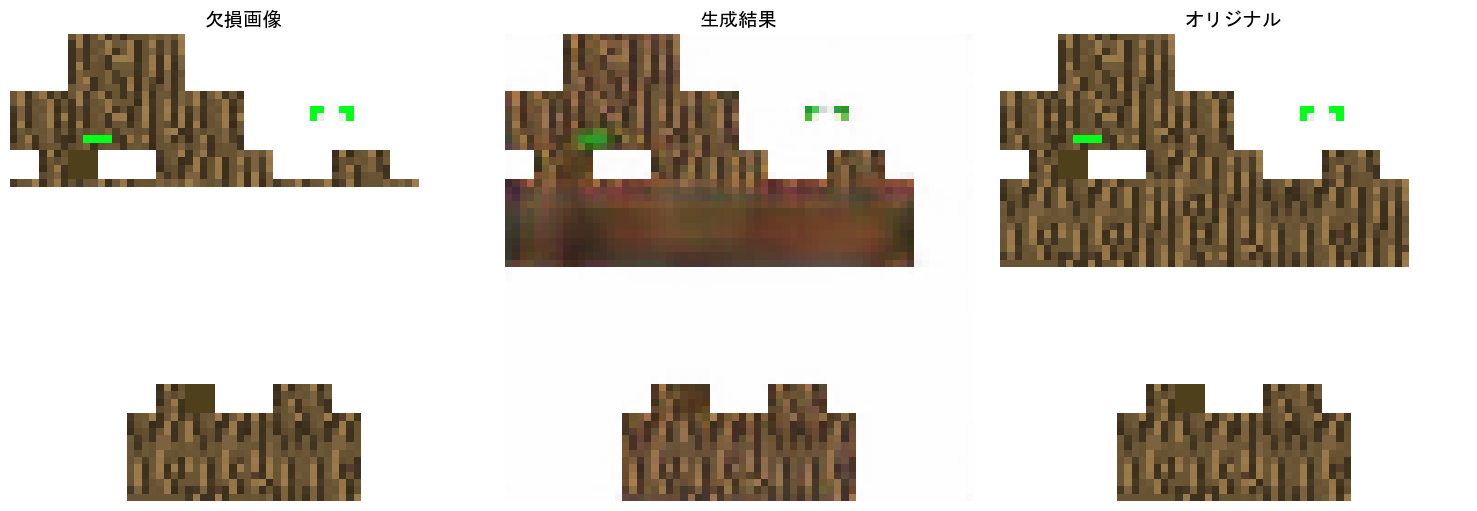

処理中: 00014339cb454055afbbb4d7a0c63a17.png
1/1 [==============================] - 0s 20ms/step


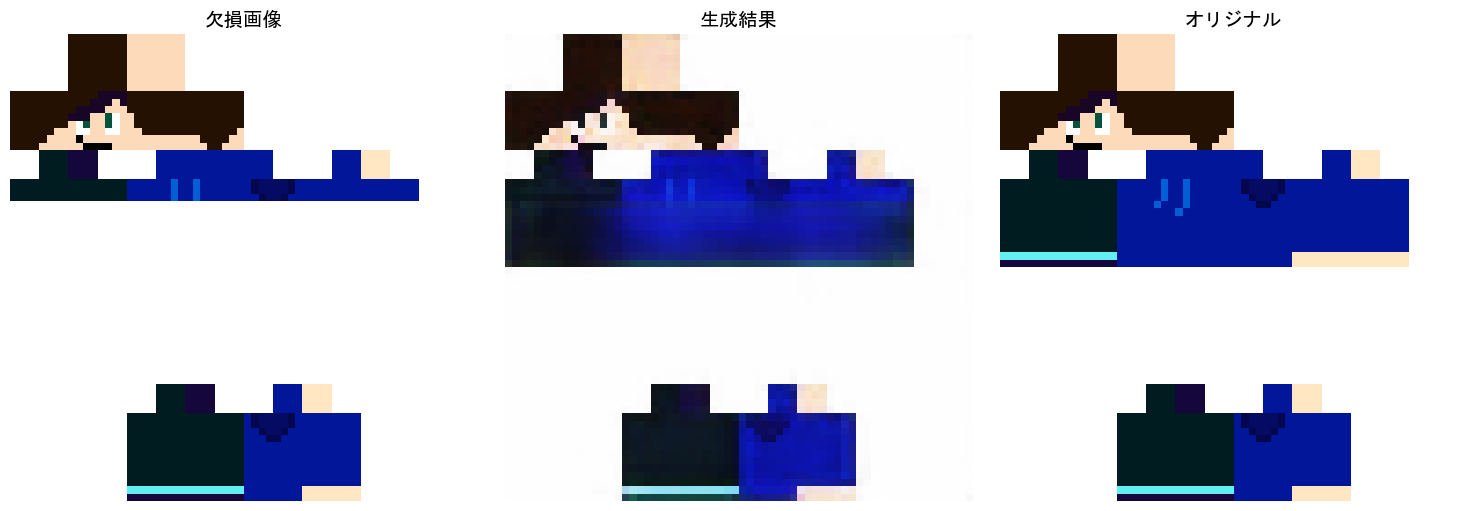

処理中: 000171e1be5b457db6b0981e83552763.png
1/1 [==============================] - 0s 20ms/step


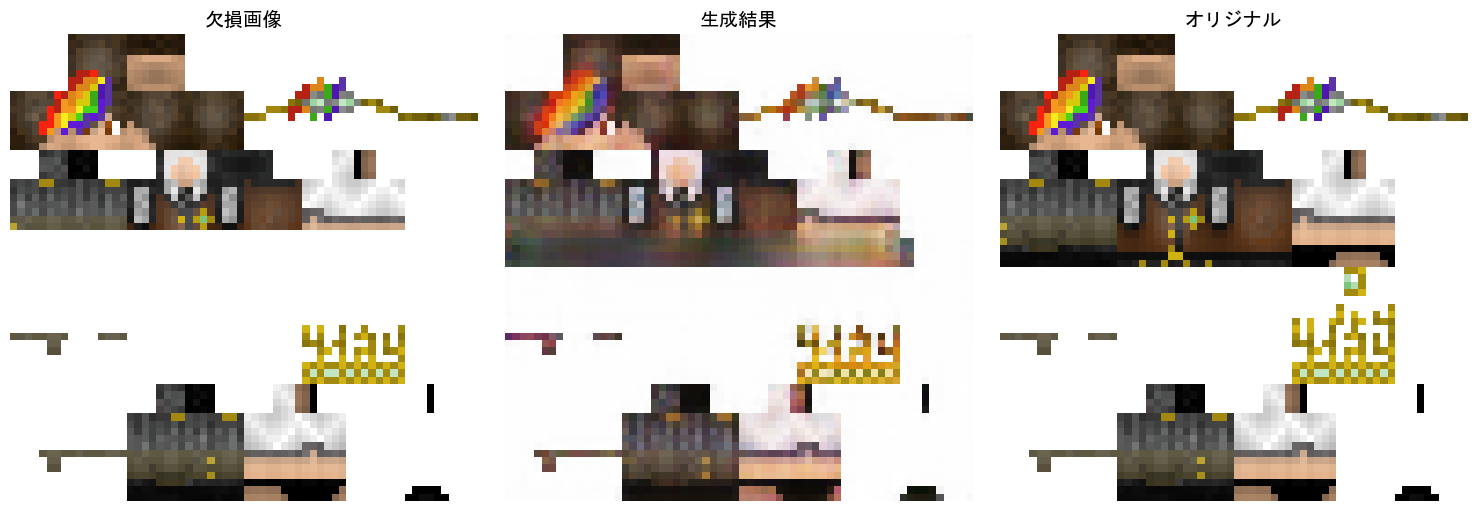

処理中: 00017f024d6f4d7f928ce6668aeff717.png
1/1 [==============================] - 0s 20ms/step


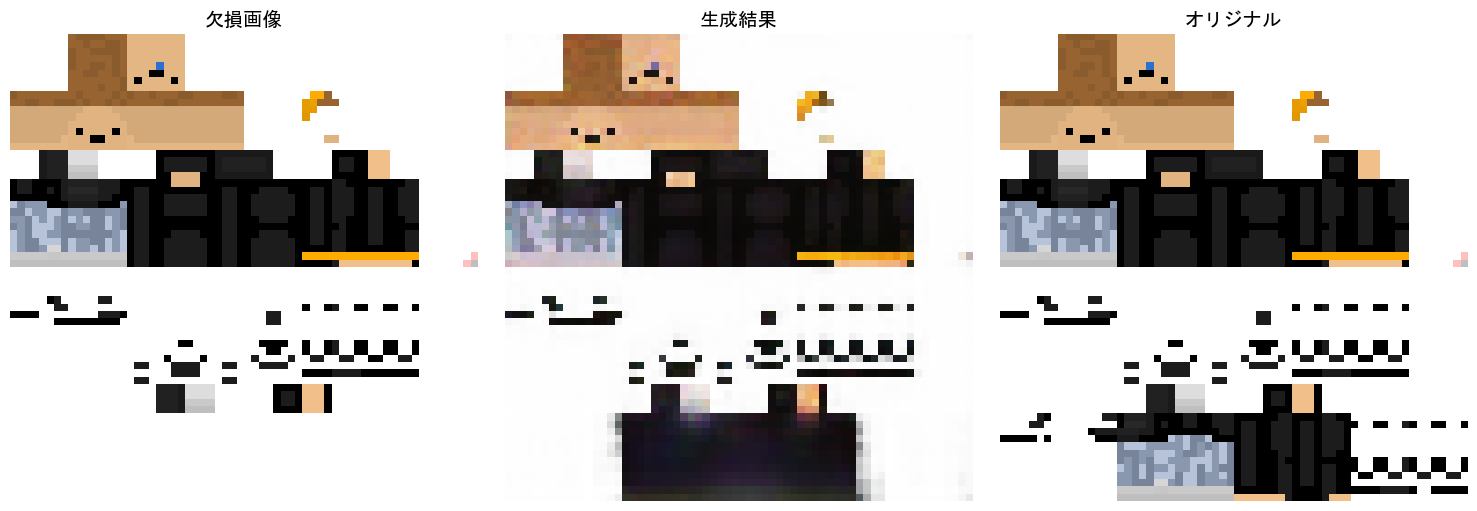

処理中: 00019ff2683a42dca4b7d631fdce2265.png
1/1 [==============================] - 0s 20ms/step


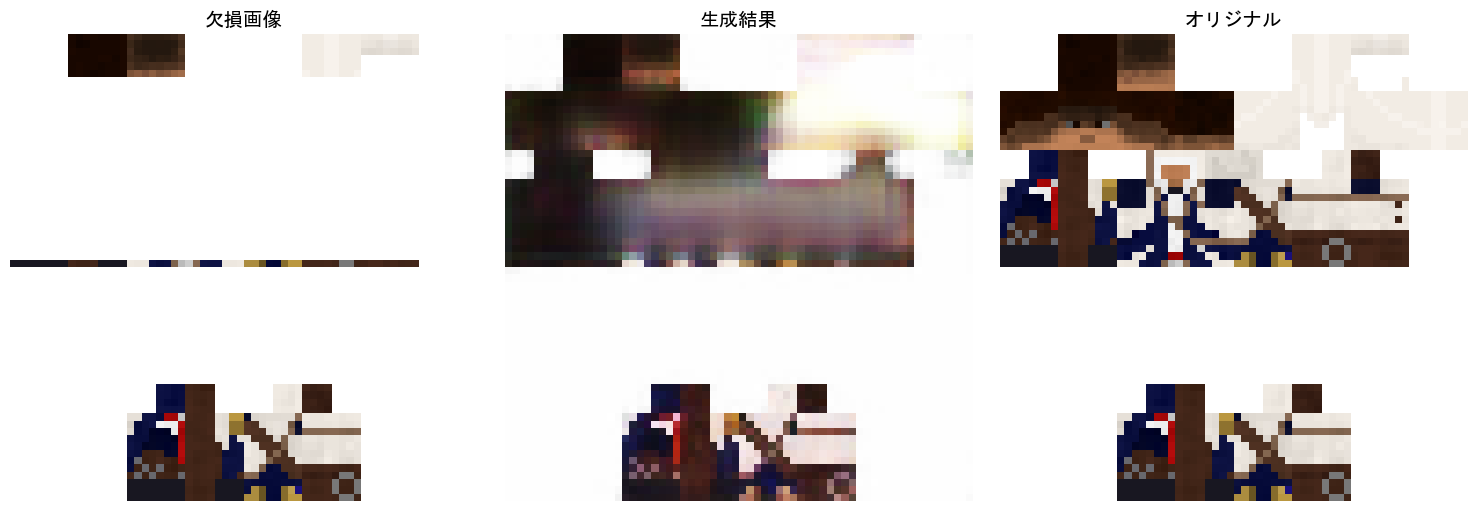

処理中: 0001b168823540eaa8a6c1abe0dfe297.png
1/1 [==============================] - 0s 20ms/step


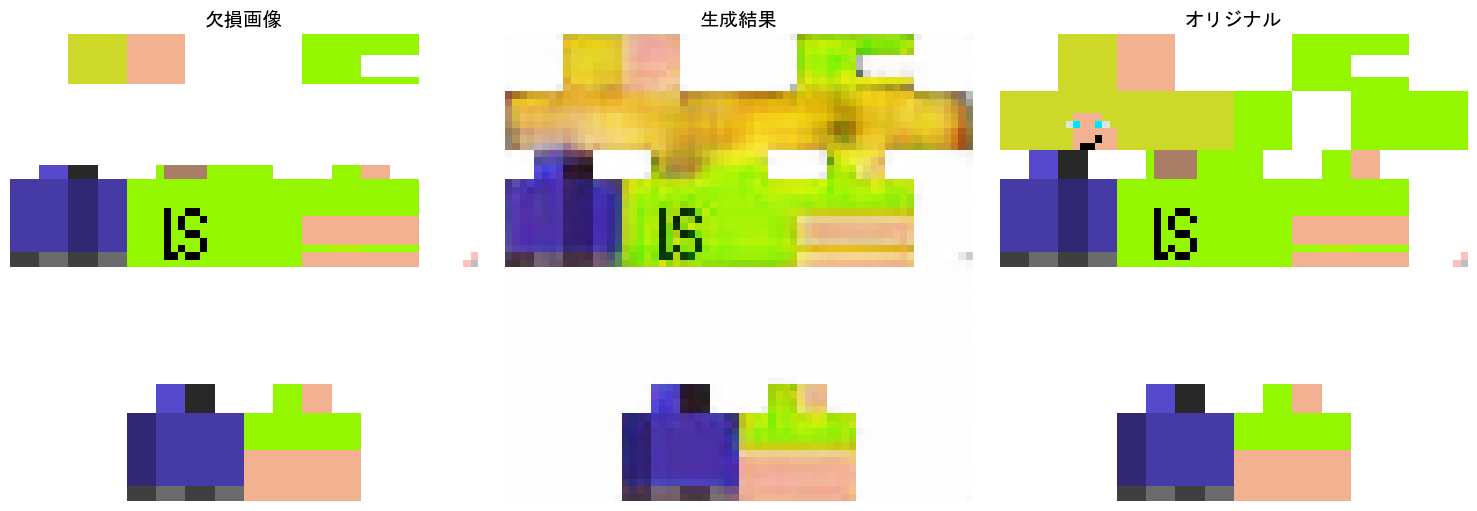

処理中: 0001b5a0e7d54741a93150fa3efa4efd.png
1/1 [==============================] - 0s 20ms/step


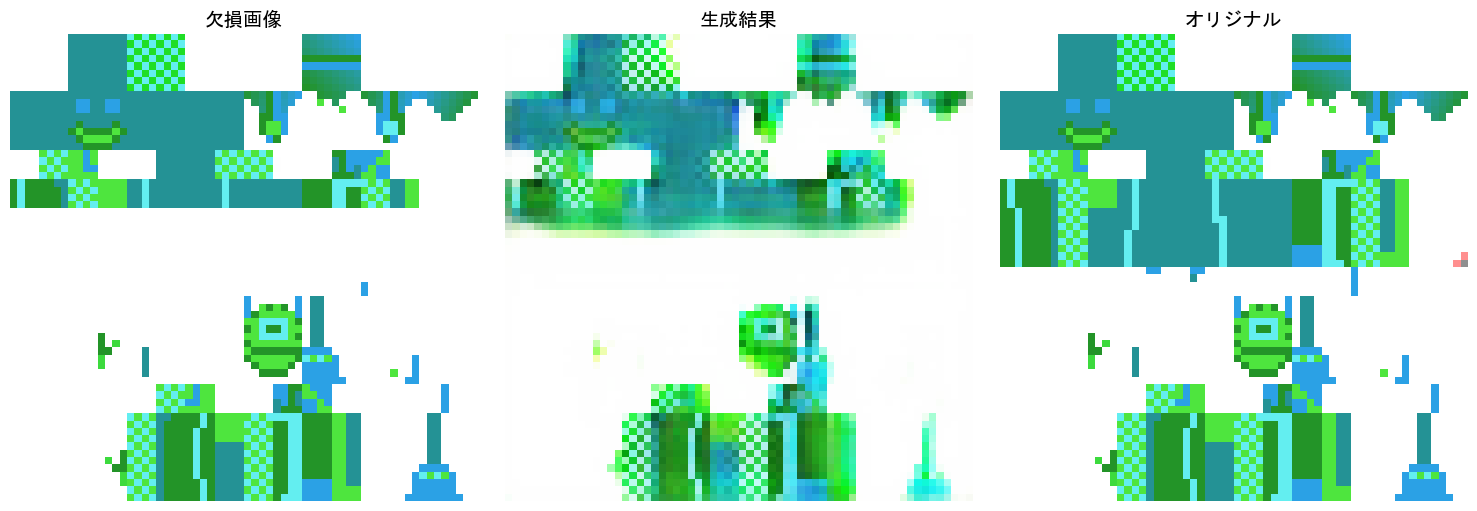

処理中: 0001ba5d9c244201858b494049799573.png
1/1 [==============================] - 0s 21ms/step


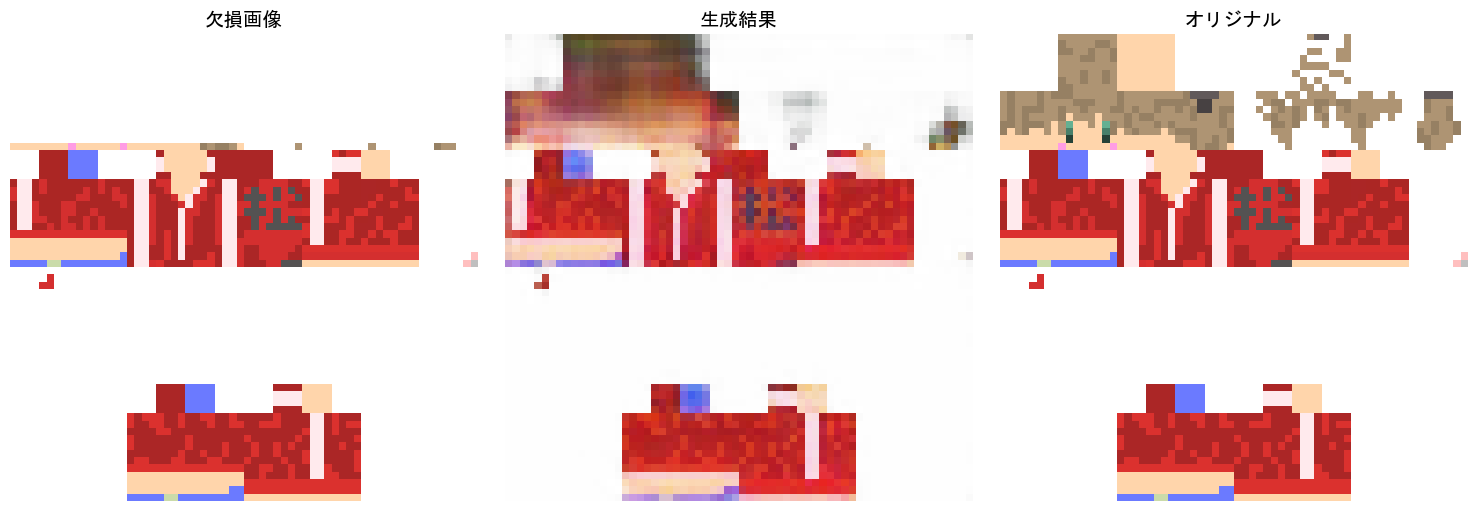

処理中: 0001d5de2b0f43ddbc21d226362935a8.png
1/1 [==============================] - 0s 21ms/step


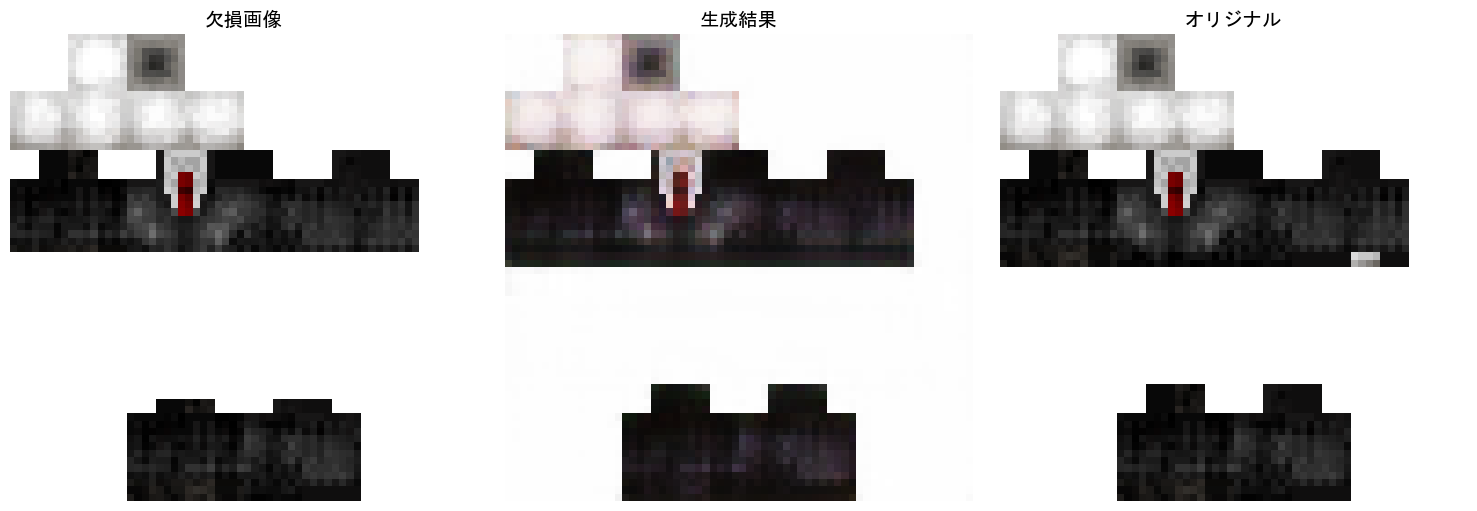

処理中: 0001f9c2445b4336868a0a2ab8940152.png
1/1 [==============================] - 0s 22ms/step


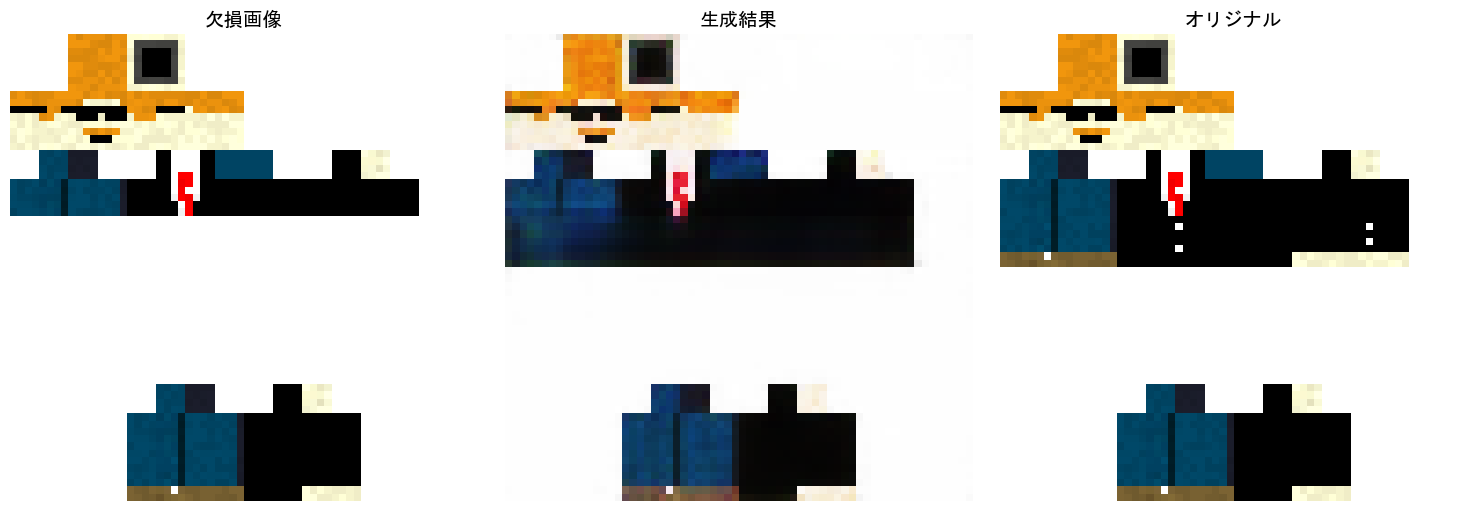

処理中: 00020c90f5a14bba884df29136b5c29e.png
1/1 [==============================] - 0s 21ms/step


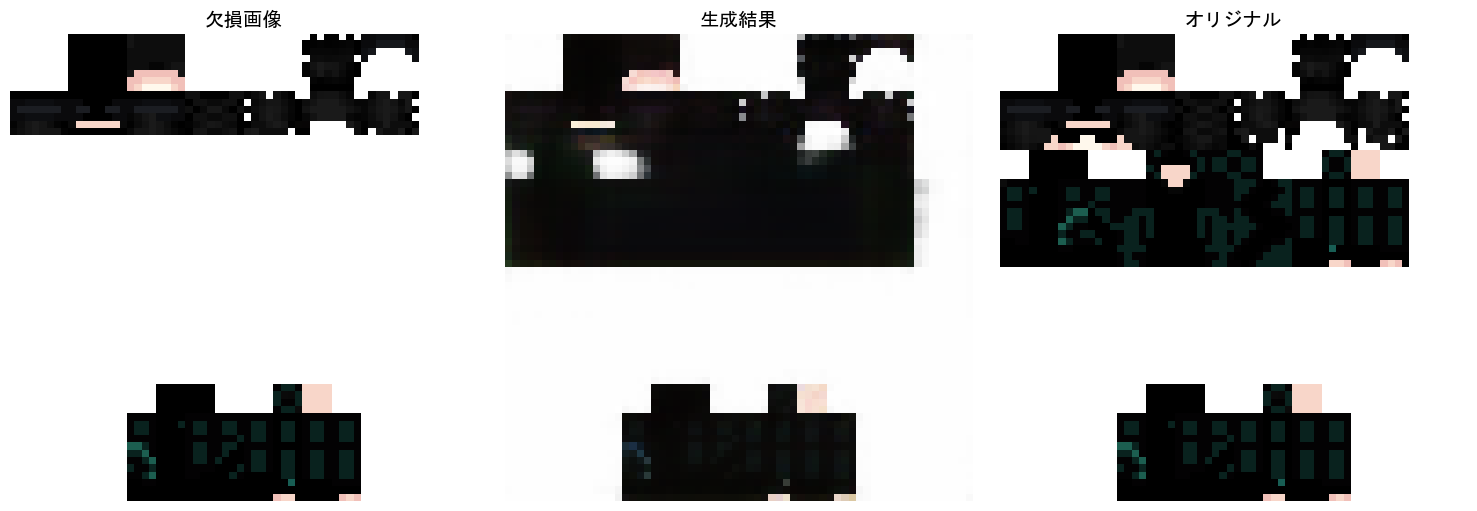

処理中: 000219123bb249eaa2b449c75073d42a.png
1/1 [==============================] - 0s 21ms/step


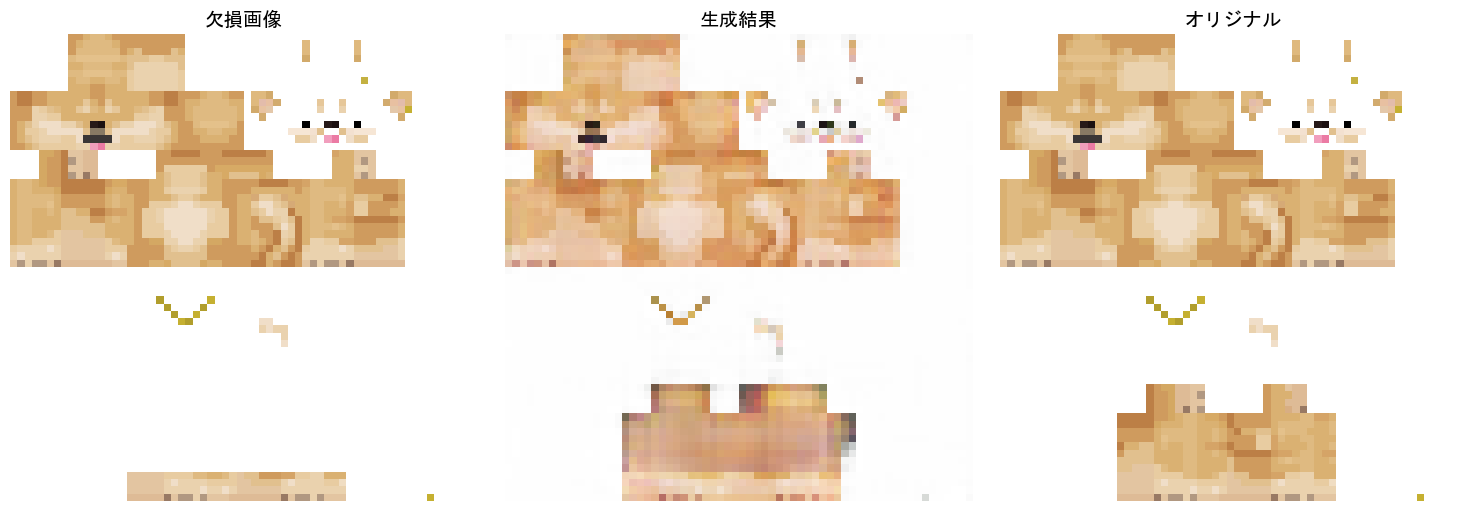

処理中: 0002197d3a434969b4c6cd216b64e0fc.png
1/1 [==============================] - 0s 20ms/step


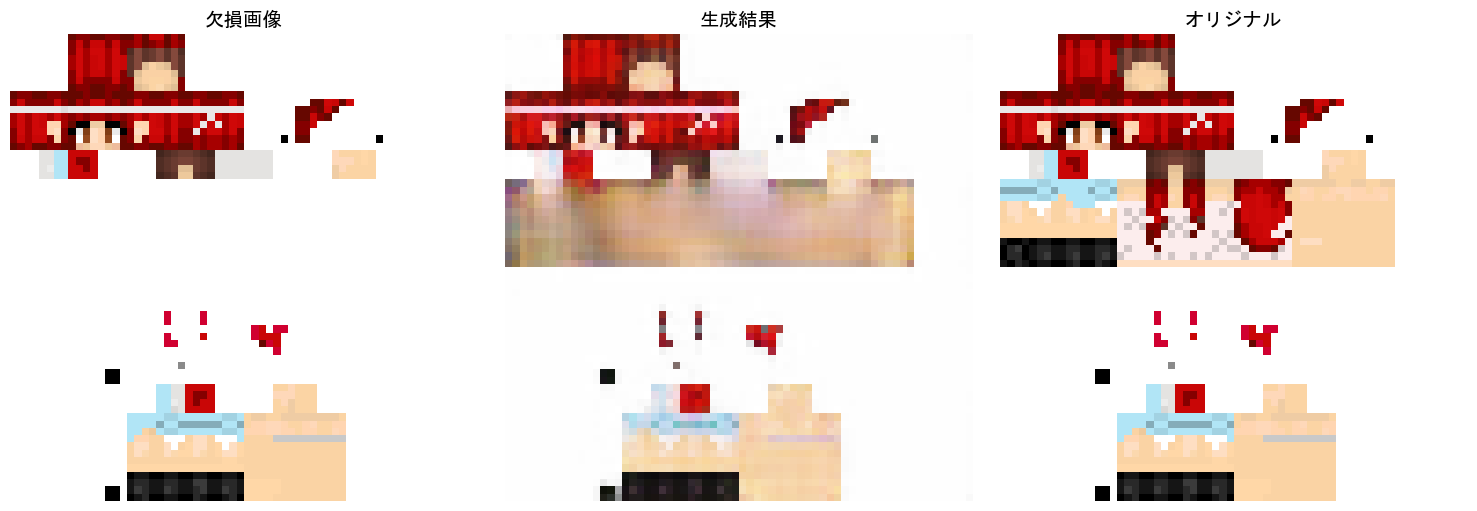

推論処理が完了しました。結果は以下のディレクトリに保存されています:
C:/Users/Owner/Desktop/archive/Results


In [25]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import matplotlib as mpl

# 日本語フォントの設定
# Windows の場合
plt.rcParams['font.family'] = 'MS Gothic'  # Windows 標準の日本語フォント
# あるいは IPAフォントなどがインストール済みの場合
# plt.rcParams['font.family'] = 'IPAGothic'

# Mac の場合はコメントアウトを外す
# plt.rcParams['font.family'] = 'Hiragino Sans GB'

# Linux の場合はコメントアウトを外す
# plt.rcParams['font.family'] = 'Noto Sans CJK JP'

# ディレクトリパス設定
skins_dir = 'C:/Users/Owner/Desktop/archive/Skins'
missing_dir = 'C:/Users/Owner/Desktop/archive/Missing'
masks_dir = 'C:/Users/Owner/Desktop/archive/Masks'
output_dir = 'C:/Users/Owner/Desktop/archive/Results'

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 画像読み込み関数
def load_image(path, channels=4):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]に正規化
    return image

# 推論用サンプルの準備
def prepare_inference_sample(file_name):
    # ファイル名からパスを生成
    missing_file = tf.strings.join(["missing_", file_name])
    missing_path = tf.strings.join([missing_dir, missing_file], separator='/')
    mask_file = tf.strings.join(["mask_", file_name])
    mask_path = tf.strings.join([masks_dir, mask_file], separator='/')
    
    # 画像とマスクを読み込み
    missing = load_image(missing_path, channels=4)
    mask = load_image(mask_path, channels=1)
    
    # 入力は欠損画像とマスクをチャネル方向に連結
    input_image = tf.concat([missing, mask], axis=-1)
    
    # バッチ次元を追加
    input_image = tf.expand_dims(input_image, 0)
    
    return input_image, file_name

# 保存された学習済みモデルを読み込む
model = load_model('U_NET/UNETsa_1000_2.h5')

# テスト用画像ファイル名のリストを取得
test_files = os.listdir(skins_dir)
test_files = [f for f in test_files if f.endswith('.png')]

# テスト画像数の制限（必要に応じて）
test_limit = 30
test_files = test_files[:test_limit]

# 各テスト画像に対して推論を実行
for file_name in test_files:
    # 推論用サンプルを準備
    input_image, file_name_tensor = prepare_inference_sample(file_name)
    
    # 推論実行
    predicted_skin = model.predict(input_image)
    
    # バッチ次元を削除
    predicted_skin = predicted_skin[0]
    
    # 元の欠損画像とマスクも読み込む（比較用）
    missing_path = os.path.join(missing_dir, f"missing_{file_name}")
    missing_image = load_image(missing_path).numpy()
    
    original_path = os.path.join(skins_dir, file_name)
    original_image = load_image(original_path).numpy()
    
    # 結果の可視化と保存
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('欠損画像', fontsize=14)
    plt.imshow(missing_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('生成結果', fontsize=14)
    plt.imshow(predicted_skin)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('オリジナル', fontsize=14)
    plt.imshow(original_image)
    plt.axis('off')
    
    # タイトルがきちんと表示されるよう余白調整
    plt.tight_layout()
    
    # 画像として保存
    plt.savefig(os.path.join(output_dir, f"result_{file_name}"))
    plt.close()
    
    # 生成された画像も個別に保存（PNG形式で）
    predicted_skin_uint8 = (predicted_skin * 255).astype(np.uint8)
    tf.io.write_file(
        os.path.join(output_dir, f"pred_{file_name}"),
        tf.image.encode_png(predicted_skin_uint8)
    )
    
    print(f"推論完了: {file_name}")

# バッチ処理版（より効率的な処理が必要な場合）
def batch_inference(batch_size=16):
    # ファイルのリストを取得
    file_names = tf.data.Dataset.list_files(os.path.join(skins_dir, '*.png'))
    
    # 推論用データセット作成関数
    def process_path(path):
        file_name = tf.strings.split(path, os.sep)[-1]
        input_image, _ = prepare_inference_sample(file_name)
        return input_image, file_name
    
    # データセット作成
    test_dataset = file_names.map(process_path).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # バッチ単位で推論
    for batch_inputs, batch_filenames in test_dataset:
        # 推論実行
        batch_predictions = model.predict(batch_inputs)
        
        # 各予測結果を保存
        for i, filename in enumerate(batch_filenames):
            filename_str = filename.numpy().decode('utf-8')
            pred_image = batch_predictions[i]
            
            # 画像として保存
            pred_image_uint8 = (pred_image * 255).astype(np.uint8)
            tf.io.write_file(
                os.path.join(output_dir, f"pred_{filename_str}"),
                tf.image.encode_png(pred_image_uint8)
            )
            
        print(f"バッチ処理完了: {len(batch_filenames)}ファイル")

# 単一画像の推論を行う関数（特定の画像に対して処理したい場合）
def infer_single_image(filename):
    # 推論用サンプルを準備
    input_image, _ = prepare_inference_sample(filename)
    
    # 推論実行
    predicted_skin = model.predict(input_image)[0]
    
    # 元の画像も読み込む（比較用）
    missing_path = os.path.join(missing_dir, f"missing_{filename}")
    missing_image = load_image(missing_path).numpy()
    
    original_path = os.path.join(skins_dir, filename)
    original_image = load_image(original_path).numpy()
    
    # 結果の可視化と表示
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('欠損画像', fontsize=14)
    plt.imshow(missing_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('生成結果', fontsize=14)
    plt.imshow(predicted_skin)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('オリジナル', fontsize=14)
    plt.imshow(original_image)
    plt.axis('off')
    
    # タイトルがきちんと表示されるよう余白調整
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_dir, f"result_{filename}"))
    plt.show()
    
    # 生成された画像も個別に保存
    predicted_skin_uint8 = (predicted_skin * 255).astype(np.uint8)
    tf.io.write_file(
        os.path.join(output_dir, f"pred_{filename}"),
        tf.image.encode_png(predicted_skin_uint8)
    )
    
    return predicted_skin

# メイン実行部分
if __name__ == "__main__":
    # フォント設定の確認
    print("利用可能なフォント:")
    print(mpl.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
    
    # 個別の画像で推論を実行する例
    # infer_single_image("example.png")
    
    # 全てのテスト画像で推論を実行
    print("個別推論処理を開始します...")
    for file_name in test_files:
        print(f"処理中: {file_name}")
        infer_single_image(file_name)
    
    # または、より効率的なバッチ処理で推論
    # print("バッチ推論処理を開始します...")
    # batch_inference(batch_size=16)
    
    print("推論処理が完了しました。結果は以下のディレクトリに保存されています:")
    print(output_dir)